In [1]:
# Gravitational Lensing Research
# Program to take a qlens-generated sample chain, derive kappa vs. radius values, then plot +/- 1-sigma bands
# along with the kappa values versus radius.
# This version is for MS2137.

In [2]:
import time
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
import timeit
from IPython.core.debugger import set_trace
import datetime

In [3]:
# set the radii values, log spaced NOTE THAT THESE MUST MATCH SCRIPT BELOW
rstart = .1
rstop  = 100.
nr = 40
radii = np.logspace(np.log10(rstart), np.log10(rstop), nr, endpoint=False)

In [4]:
# for parallel processing
import multiprocessing as mp
nproc = 4

In [5]:
# The current working directory should be the "chains_..." subdirectory for the run of interest.
print(os.getcwd())

/home/kea/KEVIN/UCI/Research/gravlensing/Python


In [6]:
# now calculated the median and +/- 1-sigma values
def find_bands(p, samples):
    total = [np.sum(samples[:, i + p] * samples[:, 0]) for i in range(nr)]
    sigma_minus  = np.zeros(nr)
    sigma_plus = np.zeros(nr)
    median = np.zeros(nr)
    for i in range(nr):
        runsum = 0.
        sm_flag = sp_flag = m_flag = False
        # sort the table by increasing kappa for the radius in question
        samsort =  samples[samples[:, i + p].argsort()]
        for row in range(len(samsort)):
            runsum += (samsort[row, 0] * samsort[row, i + p]) / total[i]
            if (not sm_flag) and (runsum > 0.158):
                sm_flag = True
                sigma_minus[i] = samsort[row, i + p]
            if (not sp_flag) and (runsum > 0.841):
                sp_flag = True
                sigma_plus[i] = samsort[row, i + p] 
            if (not m_flag) and (runsum > 0.5):
                m_flag = True
                median[i] = samsort[row, i + p]
    return sigma_minus, sigma_plus, median

In [7]:
def ql_script(i, p, params, tstart, ns):
    # assembles and runs the QLens script, returning a vector of kappa values
    # Note that the first and pth columns are not parameters.
    # the pth column is the chi square.
    like,  mvir, c, rc_kpc, q, theta, xc, yc, shear1, shear2, mtot1, mtot2, raw_chisq, chisq = params[0:p] 
    pars1 = ' '.join([str(item) for item in [mvir, c, rc_kpc, q, theta, xc, yc]])

    pars2 = ' '.join([str(item) for item in [shear1, shear2]])

    pars3 = ' '.join([str(item) for item in [mtot1, 15.0, 0.3, .92, -17.5, 0., 0. ] ])

    pars4 = ' '.join([str(item) for item in [mtot2, 3.84, 0.3, 0.465, -52.12, -9.2, 14.0]])

    kappaname = 'plotdata/kappadist_temp_' + str(mp.current_process().name) + '.dat'

    script_part_a1 = '''
    # MS2137
    zlens = 0.314  # 4.6 kpc/arcsec
    zsrc_ref = 3.0
    fit method multinest
    shear_components on
    major_axis_along_y off    
    central_image on  # REVIEW
    galsubgrid on
    gridtype cartesian
    n_livepts = 4000 
    chisqmag on 
    chisqtol 1e-6 
    chisq_time_delays off 
    analytic_bestfit_src on	
    imgplane_chisq off
    sci_notation off
    chisq_imgsep_threshold = 1e-3  
    nimg_penalty off                 
    chisq_mag_threshold = 0.1  

    chisqflux off
    chisq_time_delays off

    galsubgrid_near_imgs on

    imgdata read ../MS2137_SL_Data_V4.dat   #REVIEW
    '''

    script_part_a2 = '''
    lens clear
    lens cnfw pmode=3 '''
    # here we insert the parameters for the first lens (halo)

    script_part_b1 =''' shear='''
    # here we insert the paramters for the shear
    
    script_part_b1b ='''
    lens pjaffe pmode=2 '''
    # here we insert the parameters for the second lens (BCG)

    script_part_b2 ='''
    lens pjaffe pmode=2 '''
    # here we insert the params for perturber 1

    script_part_c = '''
    plotkappa ''' + str(rstart) + ' ' + str(rstop) + ' ' + str(nr) + ' '

    
    script = script_part_a1 + script_part_a2 + pars1 + script_part_b1 + pars2\
        + script_part_b1b + pars3 + script_part_b2 + pars4  \
        + script_part_c + kappaname  + '\n'
    sc_name = 'plotdata/kappascript_' + str(mp.current_process().name) + '.in'

    with open(sc_name, 'w') as outfile:
        outfile.write(script)

    # Now, run the script
    os.system('qlens ' + sc_name + ' -q')
    # read in kappa file back in, and store results
    kdat = np.loadtxt(kappaname)
    kappa = kdat[:, 1]
    if i==0:
        rad = kdat[:, 0]
        assert np.all(np.abs((rad - radii) / radii) < .001)
    if i%50 == 1:
        tavg = (timeit.default_timer() - tstart) / (i+1.)
        proj_fin =  tavg * (ns -i -1)
        sys.stdout.write("\r{0:5.2%} complete. Avg time per iteration: {1:8.6f} sec. Projected finish in {2:4.2f} min. "\
                   .format((float(i) / ns), tavg,  proj_fin/60))
    sys.stdout.flush() # required in multiprocessing or else it buffers this output
    return kappa

In [8]:
# Function to load cNFW chain, create the script, run it, find the bands, and return the new samples and bands.
def cNFW_script(label, path): # the path should be the /chains_... directory
    os.chdir(path)
    print(os.getcwd())
    # Import the chain
    samples = np.loadtxt(path + '/' + label, comments="#", delimiter=None, unpack=False)
    with open(path + '/' + label + '.paramnames') as afile:
        paramnames = afile.readlines()
    paramnames = [item[:-1] for item in paramnames]  # Strip off the \n character.
    samples = np.array(samples)
    ns, p = samples.shape
    print(samples.shape)
    print(paramnames)

    # extend the samples to have nr additional columns
    samples2 = np.append(samples, np.zeros((ns, nr)), axis=1)
    samples2.shape
    # delete all samples with zero weight
    mask = [False if sam[0]==0. else True for sam in samples2]
    samples2 = samples2[mask]
    print(samples2.shape)
    ns = samples2.shape[0]
    sort = samples2[samples2[:,0].argsort()]  # This sorts the samples in ascending order, based on weight (first col.)
 
    # make sure there is a directory called plotdata. If not, create it.
    if not os.path.exists(os.getcwd()+'/plotdata'):
        os.makedirs(os.getcwd()+'/plotdata')
    
    # Trying the concurrent futures method
    import concurrent.futures as cf
    results = []
    tstart = timeit.default_timer()
    with cf.ProcessPoolExecutor(nproc) as pp:
        for i, params in enumerate(samples2[:, 0:p]):
            results.append((i, pp.submit(ql_script, i, p, params, tstart, ns)))
    # code waits here until all processes are finished
    print("\nKappa calculation completed in ", (timeit.default_timer() - tstart)/60, " minutes.                          ")
    
    old_i = -1
    for (i,k) in results:
        samples2[i, p:] = k.result()
        if old_i +1 != i:
            print('WARNING: Out of order at i=', i)
        old_i = i
    print('Results saved into samples array.')  
    
    sm, sp, med = find_bands(p, samples2)
    return samples2, sm, sp, med
    

In [9]:
# The concurrent futures method has an issue here. It runs through the iterations quickly to load the queue,
# then there is no output while the processes complete. If you want progress, you would have to pass some
# info to the function being paralleled and have it print progress.

In [10]:
name = 'MS2137'
suffix = '.cnfw.v11b'
label = name + suffix
path = '/home/kea/KEVIN/UCI/Research/gravlensing/' + name + '/chains_' + label
# path = '/Users/kevin/CloudStation/KEVIN/UCI/Research/gravlensing/' + name + '/chains_' + label
samp, sigma_minus, sigma_plus, median = cNFW_script(label, path)

/home/kea/KEVIN/UCI/Research/gravlensing/MS2137/chains_MS2137.cnfw.v11b
(128134, 14)
['mvir', 'c', 'rc_kpc', 'q', 'theta', 'xc', 'yc', 'shear1', 'shear2', 'mtot1', 'mtot2', 'raw_chisq']
(128134, 54)
99.97% complete. Avg time per iteration: 0.049075 sec. Projected finish in 0.03 min.   
Kappa calculation completed in  104.8035009143668  minutes.                          
Results saved into samples array.


In [11]:
np.savez(label + '.bands', radii, sigma_minus, sigma_plus, median)

In [12]:
rad_list = []
lower_line = []
upper_line = []
median_line = []
label_list = []
rad_list.append(radii)
lower_line.append(sigma_minus)
upper_line.append(sigma_plus)
median_line.append(median)
label_list.append(label)

In [13]:
sys.exit()

SystemExit: 

/home/kea/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [36]:
# if desired, load other kappa bands created in other notebooks
# Note that they must use the same radii values
load_others = True
if load_others:
    labels = ['MS2137.cnfw.v11', 'MS2137.cnfw.v11c','MS2137.cnfw.v11d'] # you can put a list here of more than one label if you want
    for lab in labels:
        long_fn = '/home/kea/KEVIN/UCI/Research/gravlensing/MS2137/chains_'+ lab + '/' +  lab + '.bands.npz'
#         long_fn = '/Users/kevin/Cloudstation/KEVIN/UCI/Research/gravlensing/MS2137/chains_' + lab + '/' +  lab + '.bands.npz'
        if os.path.isfile(long_fn):
            print('Found ', long_fn)
            f_arrays = np.load(long_fn)
            rad_list.append(f_arrays['arr_0'])
            lower_line.append(f_arrays['arr_1'])
            upper_line.append(f_arrays['arr_2'])
            median_line.append(f_arrays['arr_3'])
            label_list.append(lab)

Found  /home/kea/KEVIN/UCI/Research/gravlensing/MS2137/chains_MS2137.cnfw.v11/MS2137.cnfw.v11.bands.npz
Found  /home/kea/KEVIN/UCI/Research/gravlensing/MS2137/chains_MS2137.cnfw.v11c/MS2137.cnfw.v11c.bands.npz
Found  /home/kea/KEVIN/UCI/Research/gravlensing/MS2137/chains_MS2137.cnfw.v11d/MS2137.cnfw.v11d.bands.npz


In [37]:
add_text = True  # to put additional info on the legend
addl_text = ['log prior on c: 4 < c < 9', 'base case', 'prior on M/L: 2 < M/L < 6',\
            'log prior on c AND prior on M/L']

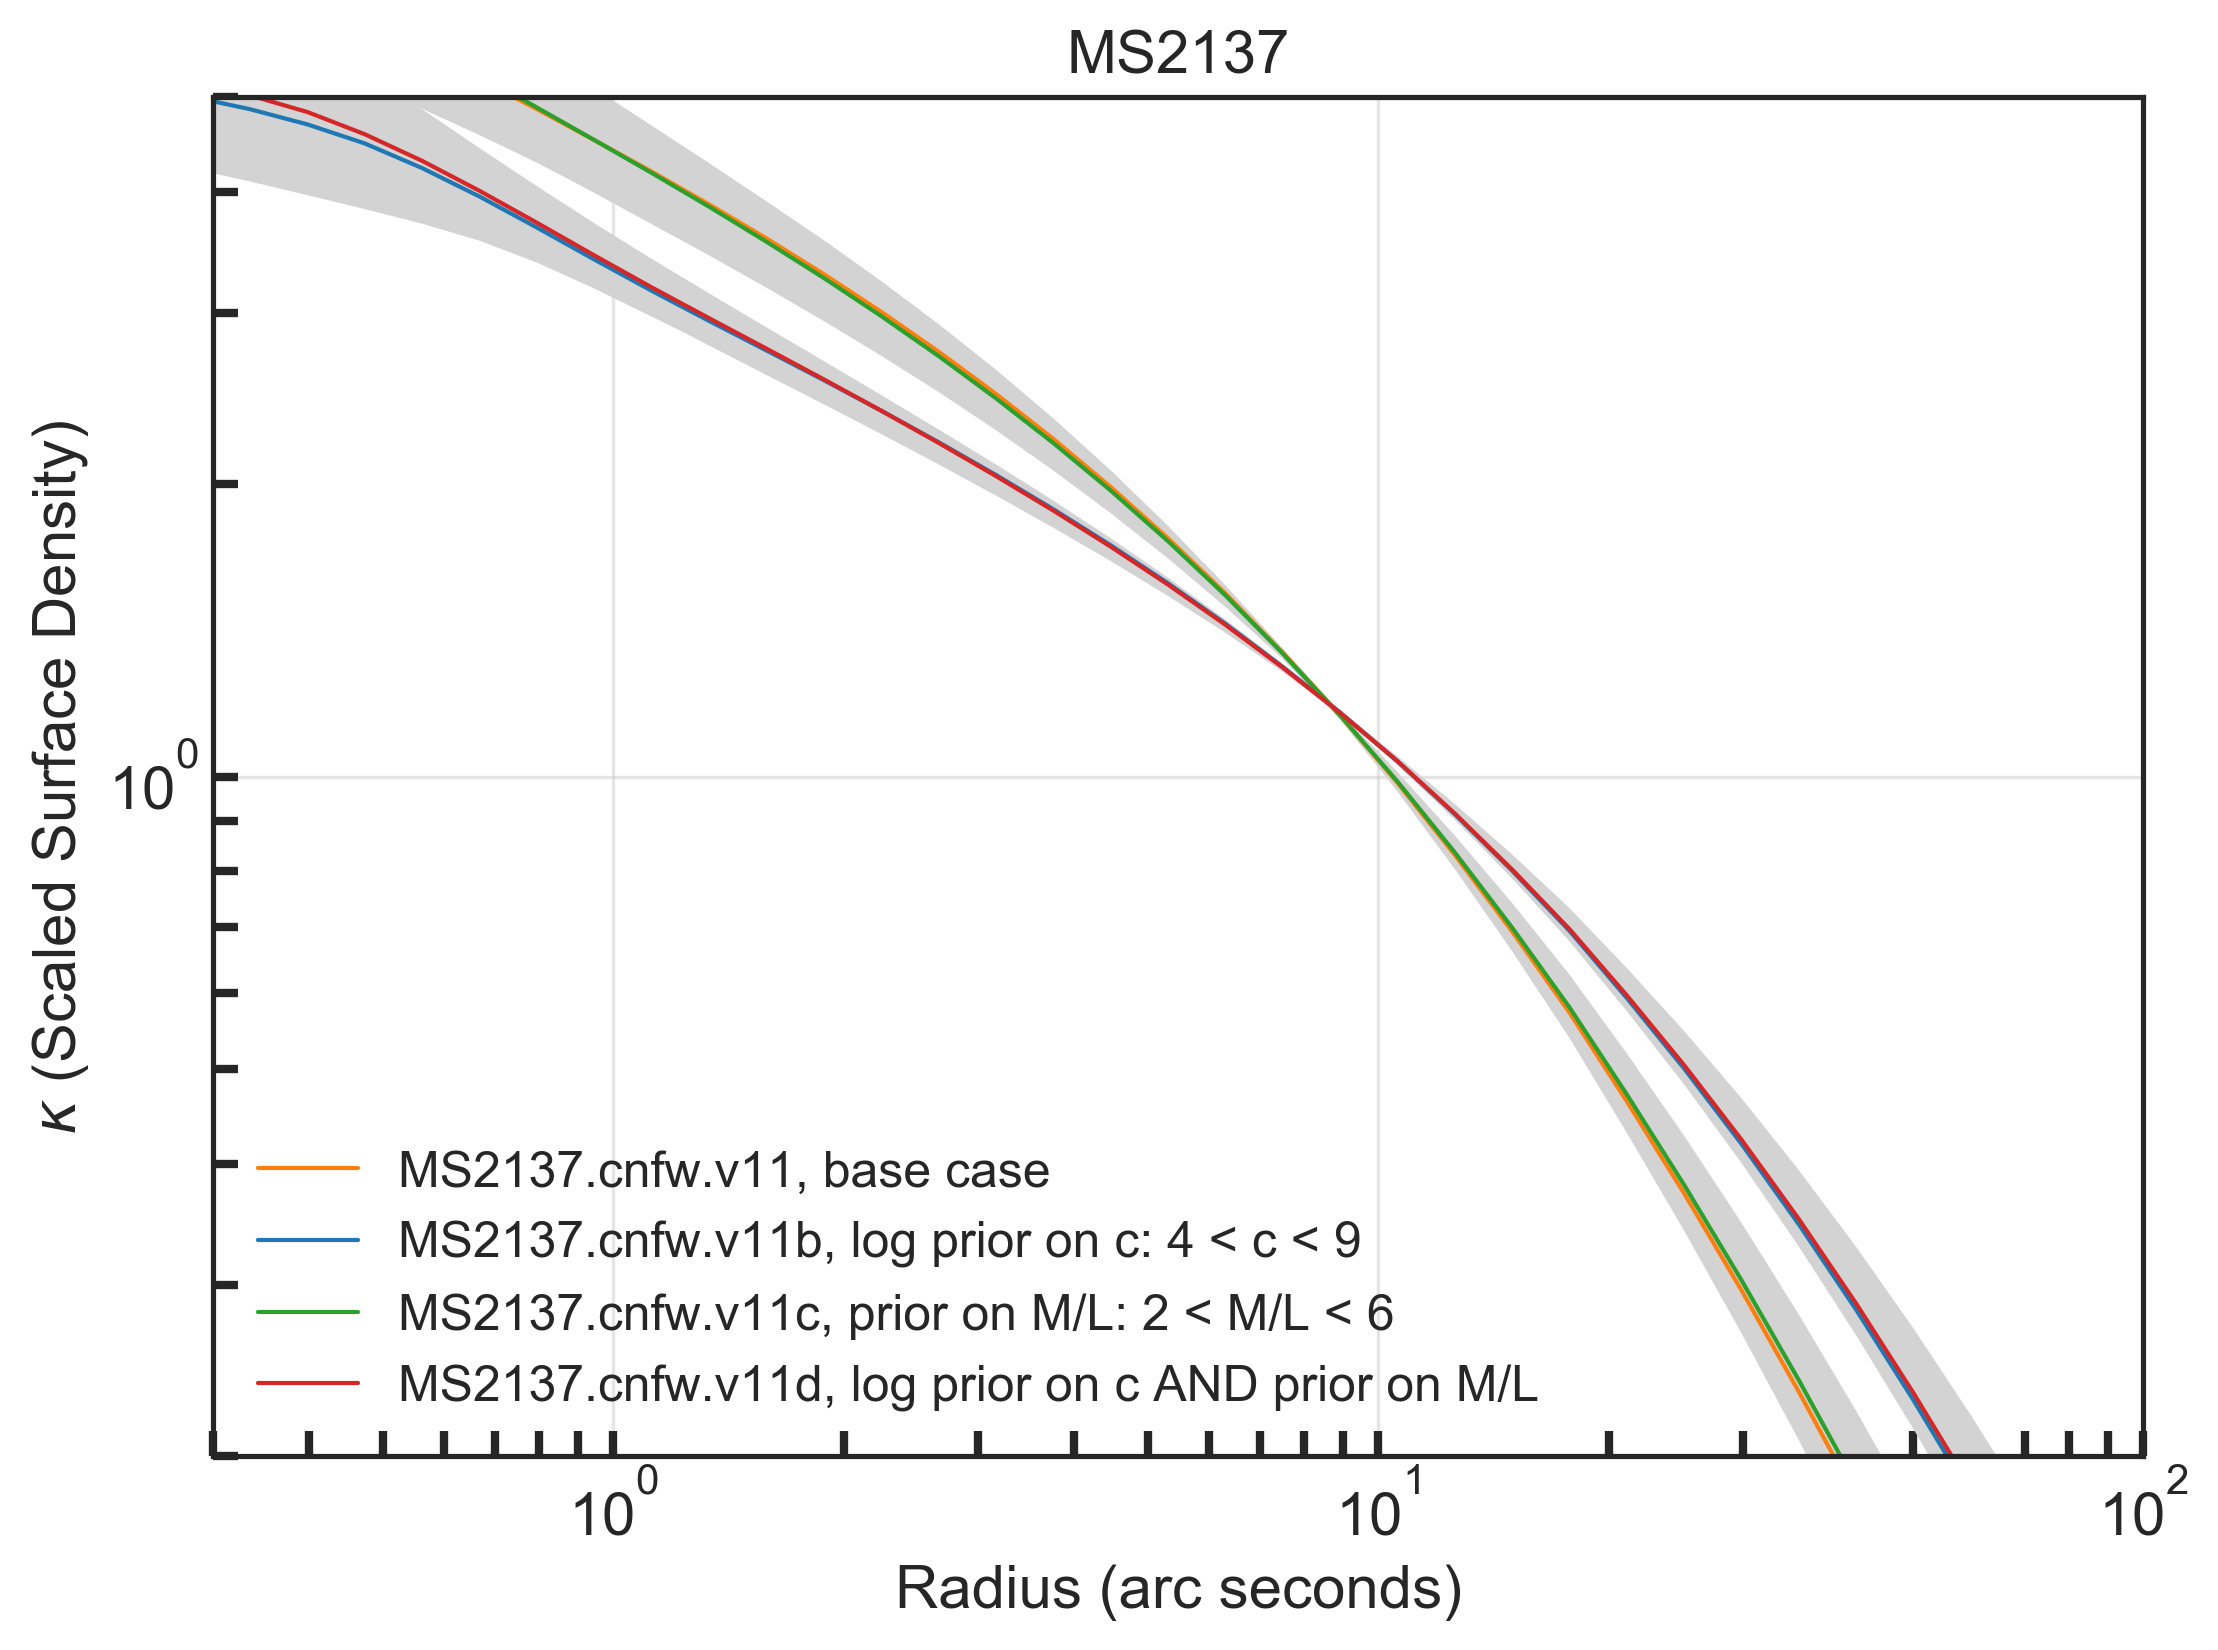

In [38]:
# Plot the kappa profiles all on the same plot.
plt.rcParams["figure.dpi"] = 300
# plt.rcParams["figure.figsize"] = [8.3, 6]
plt.rcParams.update({'legend.fontsize': 'large',
          'figure.figsize': (8.3, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          'legend.frameon': True })

plt.style.use('seaborn-ticks')
fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1)

ax.grid(which='major', alpha=0.5)
# ax.axis('equal')
plt.figure(num=1, figsize=(11, 8)) 

if add_text:
    label_text = [lab + ', ' + add for (lab, add) in zip(label_list, addl_text)]
else:
    label_text = label_list

firsttime = True
for rad, sm, sp, med, lab in zip(rad_list, lower_line, upper_line, median_line, label_text):
    if firsttime:
        ax.fill_between(rad, sm, sp, where= sp >= sm, facecolor='lightgrey',\
                interpolate=True, label= '+/- 1 ' + r'$\sigma$')
        firsttime = False
    else:
        ax.fill_between(rad, sm, sp, where= sp >= sm, facecolor='lightgrey',\
                interpolate=True)
    ax.loglog(rad, med, label=lab, linewidth=1)   

ax.tick_params(direction='in', length=6, width=2, axis='both', which='both')
ax.set_xlabel( 'Radius (arc seconds)' )
ax.set_ylabel( r'$\kappa$' )

ax.tick_params(direction='in', length=6, width=2, axis='both', which='both')
ax.set_xlabel( 'Radius (arc seconds)' )
ax.set_ylabel( r'$\kappa$ (Scaled Surface Density)' )
ax.set_title(name)
ax.set_autoscaley_on(False)
ax.set_ylim(.2, 5)
ax.set_xlim(0.3, 100)
ax.legend(frameon=True, loc='lower left')
# manually handle ordering of legend
handles, labels = plt.gca().get_legend_handles_labels()
order2 = [1, 0, 2, 3]
plt.legend([handles[idx2] for idx2 in order2],[labels[idx2] for idx2 in order2])
# ax.axvspan(7, 28, alpha=0.3, color='red')
# ax.annotate('image locations', xy=(10, .65), xytext=(2.,.65), arrowprops={'arrowstyle': '-'}\
#             , va='center')
plt.show()

In [ ]:
sys.exit()

In [ ]:
fig.savefig('../<name here>_kappadistplot.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='png',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)